# Product Classes 

Learn how to work with OPERA products using clean, minimal Python classes:
- **DispProduct** - DISP-S1 displacement
- **TropoProduct** - TROPO-ZENITH atmospheric delay
- **StaticLayer** - DISP-S1-STATIC layers (DEM, LOS, masks)
- **UnrGrid** - UNR GNSS data
- **CalProduct** - CAL-DISP calibration

In [1]:

from cal_disp.product import (
    CalProduct,
    DispProduct,
    StaticLayer,
    TropoProduct,
    UnrGrid,
    bounds_contains,
    check_bounds_coverage,
    compute_los_correction,
    interpolate_to_dem_surface,
)

## 1. DispProduct - Displacement Products

Load and work with OPERA DISP-S1 displacement products.

### Load from path

In [3]:
# Load DISP product
disp_path = "data/disp_input/OPERA_L3_DISP-S1_IW_F08882_VV_20220111T002651Z_20220722T002657Z_v1.0_20251027T005420Z.nc"
disp = DispProduct.from_path(disp_path)

print(disp)
print(f"\nFrame: {disp.frame_id}")
print(f"Sensor: {disp.sensor}")
print(f"Mode: {disp.mode}")
print(f"Polarization: {disp.polarization}")
print(f"Baseline: {disp.baseline_days} days")

DispProduct(frame=8882, 2022-01-11 → 2022-07-22, VV)

Frame: 8882
Sensor: S1
Mode: IW
Polarization: VV
Baseline: 192 days


### Open dataset

In [5]:
# Open main displacement dataset
ds = disp.open_dataset()
print("Main dataset variables:")
print(list(ds.data_vars))

# Access displacement
displacement = ds["displacement"]
print(f"\nDisplacement shape: {displacement.shape}")
print(f"Units: {displacement.attrs.get('units', 'N/A')}")

Main dataset variables:
['spatial_ref', 'reference_time', 'displacement', 'short_wavelength_displacement', 'recommended_mask', 'connected_component_labels', 'temporal_coherence', 'estimated_phase_quality', 'persistent_scatterer_mask', 'shp_counts', 'water_mask', 'phase_similarity', 'timeseries_inversion_residuals']

Displacement shape: (7733, 9464)
Units: meters


### Get bounds

In [6]:
# Get bounds in different projections
bounds_native = disp.get_bounds()
bounds_wgs84 = disp.get_bounds_wgs84()

print("Native projection bounds:")
for key, val in bounds_native.items():
    print(f"  {key}: {val:.2f}")

print("\nWGS84 bounds:")
for key, val in bounds_wgs84.items():
    print(f"  {key}: {val:.4f}°")

Native projection bounds:
  left: 71985.00
  bottom: 3153945.00
  right: 355875.00
  top: 3385905.00

WGS84 bounds:
  west: -97.4595°
  south: 28.4420°
  east: -94.4727°
  north: 30.5970°


### Access corrections group

In [7]:
# Open corrections group
ds_corr = disp.open_corrections()
print("Correction layers:")
print(list(ds_corr.data_vars))

# Access specific correction
if "ionospheric_delay" in ds_corr:
    iono = ds_corr["ionospheric_delay"]
    print(f"\nIonospheric delay shape: {iono.shape}")

Correction layers:
['spatial_ref', 'ionospheric_delay', 'solid_earth_tide', 'perpendicular_baseline', 'reference_point']

Ionospheric delay shape: (7733, 9464)


### Export to GeoTIFF

In [8]:
# Export displacement layer
output_path = disp.to_geotiff(
    layer="displacement",
    output_path="output/displacement.tif",
)
print(f"Exported to: {output_path}")

Exported to: output/displacement.tif


## 2. TropoProduct - Tropospheric Products

Work with OPERA TROPO-ZENITH atmospheric delay products.

### Load and inspect

In [11]:
# Load TROPO product
tropo_path = "data/tropo/OPERA_L4_TROPO-ZENITH_20220111T000000Z_20250923T224940Z_HRES_v1.0.nc"
tropo = TropoProduct.from_path(tropo_path)

print(tropo)
print(f"\nModel: {tropo.model}")
print(f"Reference time: {tropo.date}")

TropoProduct(date=2022-01-11T00:00:00, model=HRES)

Model: HRES
Reference time: 2022-01-11 00:00:00


### Get total delay

In [17]:
# Get total zenith delay (wet + hydrostatic)
delay = tropo.get_total_delay(
    time_idx=0,
    bounds=list(bounds_wgs84.values()),
    max_height=11e3,  # 11 km
    bounds_buffer=0.2,
)

print(f"Total delay shape: {delay.shape}")
print(f"Dimensions: {delay.dims}")
print(f"Coordinates: {list(delay.coords)}")

Total delay shape: (68, 36, 48)
Dimensions: ('height', 'latitude', 'longitude')
Coordinates: ['time', 'height', 'latitude', 'longitude', 'spatial_ref']


### Temporal interpolation

In [23]:
from cal_disp.product import interpolate_in_time

# Load two TROPO products
tropo_early = TropoProduct.from_path("data/tropo_input/OPERA_L4_TROPO-ZENITH_20220111T000000Z_20250923T224940Z_HRES_v1.0.nc")
tropo_late = TropoProduct.from_path("data/tropo_input/OPERA_L4_TROPO-ZENITH_20220111T060000Z_20250923T231305Z_HRES_v1.0.nc")

# Interpolate to target time
target_time = disp.primary_date # DISP primary date

delay_interp = interpolate_in_time(
    tropo_early=tropo_early,
    tropo_late=tropo_late,
    target_datetime=target_time,
    bounds=list(bounds_wgs84.values()),
    max_height=11e3,
    bounds_buffer=0.2,
)

print(f"Interpolated delay shape: {delay_interp.shape}")
print(f"Target date: {delay_interp.attrs.get('target_date')}")
print(f"Interpolation weight: {delay_interp.attrs.get('interpolation_weight'):.4f}")

Interpolated delay shape: (68, 36, 48)
Target date: 2022-01-11T00:26:51
Interpolation weight: 0.0746


### Intersect with DEM and project to LOS

In [31]:
# Load TROPO files for reference and secondary datetime
ref_tropo_1 = TropoProduct.from_path('/u/aurora-r0/govorcin/01_OPERA/CAL/cal-disp/data/tropo_input/OPERA_L4_TROPO-ZENITH_20220111T000000Z_20250923T224940Z_HRES_v1.0.nc')
ref_tropo_2 = TropoProduct.from_path('/u/aurora-r0/govorcin/01_OPERA/CAL/cal-disp/data/tropo_input/OPERA_L4_TROPO-ZENITH_20220111T060000Z_20250923T231305Z_HRES_v1.0.nc')
sec_tropo_1 = TropoProduct.from_path('/u/aurora-r0/govorcin/01_OPERA/CAL/cal-disp/data/tropo_input/OPERA_L4_TROPO-ZENITH_20220722T000000Z_20250923T233421Z_HRES_v1.0.nc')
sec_tropo_2 = TropoProduct.from_path('/u/aurora-r0/govorcin/01_OPERA/CAL/cal-disp/data/tropo_input/OPERA_L4_TROPO-ZENITH_20220722T060000Z_20250923T230822Z_HRES_v1.0.nc')

In [32]:
# Load DEM
dem_path = "data/static_input/OPERA_L3_DISP-S1-STATIC_F08882_20140403_S1A_v1.0_dem.tif"
dem = StaticLayer.from_path(dem_path)
dem = dem.to_dataset()
dem = dem.rio.write_crs(dem.attrs['crs_wkt'])
max_height = dem.dem.max().values + 3e3

In [34]:
# Interpolate nearest TROPO file to DISP reference and secondary datetime
tropo_ref_ds = interpolate_in_time(ref_tropo_1, ref_tropo_2,
                    target_datetime=disp.primary_date,
                    bounds=list(disp.get_bounds_wgs84().values()),
                    max_height=max_height, bounds_buffer=0.2)

tropo_sec_ds = interpolate_in_time(sec_tropo_1, sec_tropo_2,
                    target_datetime=disp.secondary_date,
                    bounds=list(disp.get_bounds_wgs84().values()),
                    max_height=max_height, bounds_buffer=0.2)

In [36]:
# Intersect TROPO to DEM elevation
tropo_ref_dem = interpolate_to_dem_surface(tropo_ref_ds, dem['dem'])
tropo_sec_dem = interpolate_to_dem_surface(tropo_sec_ds, dem['dem'])

In [38]:
# Load LOS dataset
los_path = "data/static_input/OPERA_L3_DISP-S1-STATIC_F08882_20140403_S1A_v1.0_line_of_sight_enu.tif"
los = StaticLayer.from_path(los_path)
los_ds = los.to_dataset()

# Project zentith to LOS slant range and save as geotif
_ = compute_los_correction(tropo_ref_dem,
                       los_ds['los_up'],
                       output_path=f'/u/aurora-r0/govorcin/01_OPERA/CAL/cal-disp/data/tropo_input/tropospheric_correction_{disp.primary_date.date().strftime("%Y%m%d")}.tif')
_ = compute_los_correction(tropo_sec_dem,
                       los_ds['los_up'],
                       output_path=f'/u/aurora-r0/govorcin/01_OPERA/CAL/cal-disp/data/tropo_input/tropospheric_correction_{disp.secondary_date.date().strftime("%Y%m%d")}.tif')

## 3. StaticLayer - Static Layers

Work with OPERA DISP-S1-STATIC layers (DEM, LOS, masks).

### Load individual layer

In [27]:
# Load DEM layer
dem_path = "data/static_input/OPERA_L3_DISP-S1-STATIC_F08882_20140403_S1A_v1.0_dem.tif"
dem = StaticLayer.from_path(dem_path)

print(dem)
print(f"\nLayer: {dem.layer_type}")
print(f"Frame: {dem.frame_id}")

StaticLayer(frame=8882, layer=dem, bands=1)

Layer: dem
Frame: 8882


### Convert to dataset

In [28]:
# Convert to xarray Dataset
ds_dem = dem.to_dataset()
print("DEM dataset:")
print(ds_dem)

# Access DEM data
dem_data = ds_dem["dem"]
print(f"\nDEM shape: {dem_data.shape}")
print(f"Min elevation: {float(dem_data.min()):.1f} m")
print(f"Max elevation: {float(dem_data.max()):.1f} m")

DEM dataset:
<xarray.Dataset> Size: 293MB
Dimensions:  (y: 7733, x: 9464)
Coordinates:
  * y        (y) float64 62kB 3.386e+06 3.386e+06 ... 3.154e+06 3.154e+06
  * x        (x) float64 76kB 7.198e+04 7.202e+04 ... 3.558e+05 3.559e+05
Data variables:
    dem      (y, x) float32 293MB 161.6 160.5 160.6 ... -26.86 -26.86 -26.86
Attributes:
    frame_id:        8882
    satellite:       S1A
    version:         1.0
    reference_date:  2014-04-03T00:00:00
    layer_type:      dem
    crs_wkt:         PROJCS["WGS 84 / UTM zone 15N",GEOGCS["WGS 84",DATUM["WG...
    epsg:            32615
    transform:       [30.0, 0.0, 71970.0, 0.0, -30.0, 3385920.0, 0.0, 0.0, 1.0]
    nodata:          None

DEM shape: (7733, 9464)
Min elevation: -41.4 m
Max elevation: 205.2 m


In [29]:
# Load LOS layer
los_path = "data/static_input/OPERA_L3_DISP-S1-STATIC_F08882_20140403_S1A_v1.0_line_of_sight_enu.tif"
los = StaticLayer.from_path(los_path)

print(los)
print(f"\nLayer: {los.layer_type}")
print(f"Frame: {los.frame_id}")

StaticLayer(frame=8882, layer=line_of_sight_enu, bands=3)

Layer: line_of_sight_enu
Frame: 8882


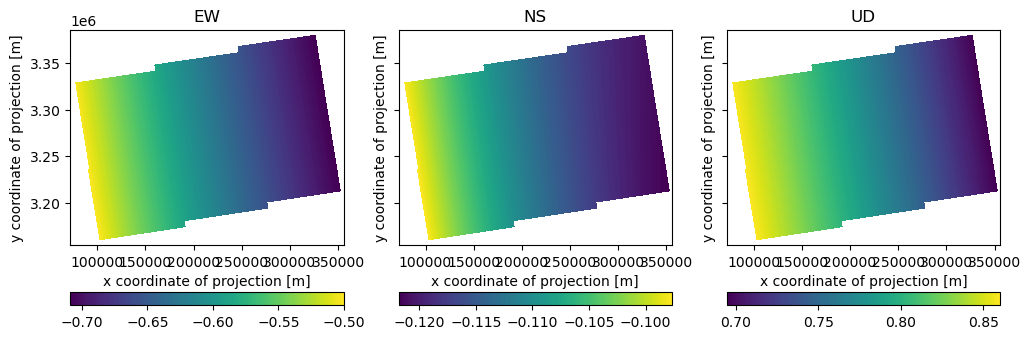

In [30]:
from matplotlib import pyplot as plt

los_ds = los.to_dataset()
fig, ax = plt.subplots(1,3, figsize=(12,4),sharey=True)
im1= los_ds.los_east.plot.imshow(ax=ax[0], add_colorbar=False)
im2= los_ds.los_north.plot.imshow(ax=ax[1], add_colorbar=False)
im3= los_ds.los_up.plot.imshow(ax=ax[2], add_colorbar=False)
for im, txt, a in zip([im1, im2, im3], ['EW', 'NS', 'UD'],ax):
    fig.colorbar(im, ax=a, location='bottom')
    a.set_title(txt)

## 4. UnrGrid - GNSS Data

Work with UNR GNSS grid data.

### Load and inspect

In [40]:
# Load UNR grid
unr_path = "data/unr_input/unr_grid_frame8882.parquet"
unr = UnrGrid.from_path(unr_path)

print(unr)
print(f"\nFrame ID: {unr.frame_id}")
print(f"Stations: {unr.get_grid_count()}")

UnrGrid(frame=8882, points=169)

Frame ID: 8882
Stations: 169


### Load as GeoDataFrame

In [43]:
# Load data
gdf = unr.load()

print("GNSS stations:")
print(gdf[['id', 'lon', 'lat', 'east', 'north', 'up']].head())

# Get bounds
bounds = unr.get_bounds()
print("\nBounds:")
for key, val in bounds.items():
    print(f"  {key}: {val:.4f}°")

GNSS stations:
     id       lon       lat      east     north        up
0  4570 -95.96719  28.62083  0.078726  0.014528  0.020513
1  4570 -95.96719  28.62083  0.080680  0.012950  0.019130
2  4570 -95.96719  28.62083  0.079684  0.013302  0.017483
3  4570 -95.96719  28.62083  0.080020  0.012809  0.016243
4  4570 -95.96719  28.62083  0.078697  0.013651  0.022810

Bounds:
  west: -97.8665°
  south: 28.1892°
  east: -94.0336°
  north: 30.9950°


### Get metadata

In [44]:
# Get metadata from parquet file
metadata = unr.get_metadata()
print("Metadata:")
for key, val in metadata.items():
    print(f"  {key}: {val}")

Metadata:
  reference_frame: IGS20
  ARROW:schema: /////4gLAAAQAAAAAAAKAA4ABgAFAAgACgAAAAABBAAQAAAAAAAKAAwAAAAEAAgACgAAAKAIAAAEAAAABQAAAPgAAADEAAAAmAAAADQAAAAEAAAAJP///xQAAAAEAAAABQAAAElHUzIwAAAADwAAAHJlZmVyZW5jZV9mcmFtZQBQ////TAAAAAQAAAA8AAAAVGltZSBzZXJpZXMgb2YgZWFzdC9ub3J0aC91cCBkaXNwbGFjZW1lbnRzIGFuZCB1bmNlcnRhaW50aWVzAAAAAAsAAABkZXNjcmlwdGlvbgCw////GAAAAAQAAAAIAAAAVU5SIGdyaWQAAAAABgAAAHNvdXJjZQAA2P///xQAAAAEAAAABAAAADg4ODIAAAAACAAAAGZyYW1lX2lkAAAAAAgADAAEAAgACAAAAIwHAAAEAAAAfAcAAHsiaW5kZXhfY29sdW1ucyI6IFt7ImtpbmQiOiAicmFuZ2UiLCAibmFtZSI6IG51bGwsICJzdGFydCI6IDAsICJzdG9wIjogODUwMDcwLCAic3RlcCI6IDF9XSwgImNvbHVtbl9pbmRleGVzIjogW3sibmFtZSI6IG51bGwsICJmaWVsZF9uYW1lIjogbnVsbCwgInBhbmRhc190eXBlIjogInVuaWNvZGUiLCAibnVtcHlfdHlwZSI6ICJvYmplY3QiLCAibWV0YWRhdGEiOiB7ImVuY29kaW5nIjogIlVURi04In19XSwgImNvbHVtbnMiOiBbeyJuYW1lIjogImlkIiwgImZpZWxkX25hbWUiOiAiaWQiLCAicGFuZGFzX3R5cGUiOiAiaW50NjQiLCAibnVtcHlfdHlwZSI6ICJpbnQ2NCIsICJtZXRhZGF0YSI6IG51bGx9LCB7Im5hbWUiOiAiZGF0ZSIsICJmaWVsZF9uYW1lIjogImRhdGUiL

## 5. CalProduct - Calibration Products

Create and work with calibration products.

### Create CalProduct

In [45]:
import numpy as np
import xarray as xr

# Create sample calibration data (zeros for demo)
ds_disp = disp.open_dataset()
shape = ds_disp["displacement"].shape
y = ds_disp.y.values
x = ds_disp.x.values

# Full resolution calibration
calibration = xr.DataArray(
    np.zeros(shape, dtype=np.float32),
    coords={"y": y, "x": x},
    dims=["y", "x"],
    attrs={"units": "meters"},
)

calibration_std = xr.DataArray(
    np.zeros(shape, dtype=np.float32),
    coords={"y": y, "x": x},
    dims=["y", "x"],
    attrs={"units": "meters"},
)

# Coarse resolution 3D model (every 167th point ~ 5km)
coarse_y = y[::167]
coarse_x = x[::167]
coarse_shape = (len(coarse_y), len(coarse_x))

model_3d = {
    "north_south": xr.DataArray(
        np.zeros(coarse_shape, dtype=np.float32),
        coords={"y": coarse_y, "x": coarse_x},
        dims=["y", "x"],
    ),
    "east_west": xr.DataArray(
        np.zeros(coarse_shape, dtype=np.float32),
        coords={"y": coarse_y, "x": coarse_x},
        dims=["y", "x"],
    ),
    "up_down": xr.DataArray(
        np.zeros(coarse_shape, dtype=np.float32),
        coords={"y": coarse_y, "x": coarse_x},
        dims=["y", "x"],
    ),
}

# Create CalProduct
cal = CalProduct.create(
    calibration=calibration,
    disp_product=disp,
    output_dir="output/",
    sensor="S1",
    calibration_std=calibration_std,
    model_3d=model_3d,
    metadata={
        "gnss_reference_epoch": "2020-01-01T00:00:00Z",
        "model_3d_resolution": "5km",
        "calibration_resolution": "30m",
    },
    version="1.0",
)

print(f"Created: {cal.filename}")
print(cal)

Created: OPERA_L4_CAL-DISP-S1_IW_F08882_VV_20220111T002651Z_20220722T002657Z_v1.0_20251231T040308Z.nc
CalProduct(sensor=S1, frame=8882, 2022-01-11 → 2022-07-22, VV+model_3d)


### Access CalProduct groups

In [46]:
# Open main group
ds_main = cal.open_dataset()
print("Main group variables:")
print(list(ds_main.data_vars))
print(f"Calibration shape: {ds_main['calibration'].shape}")

# Check for model_3d group
if cal.has_model_3d():
    ds_model = cal.open_model_3d()
    print("\nModel 3D group variables:")
    print(list(ds_model.data_vars))
    print(f"Up-down shape: {ds_model['up_down'].shape}")

Main group variables:
['calibration', 'calibration_std']
Calibration shape: (7733, 9464)

Model 3D group variables:
['north_south', 'east_west', 'up_down']
Up-down shape: (47, 57)


### Export CalProduct layers

In [47]:
# Export main calibration
cal.to_geotiff("calibration", "output/calibration.tif")

# Export 3D model component
if cal.has_model_3d():
    cal.to_geotiff("up_down", "output/model_up.tif", group="model_3d")

print("Exported calibration layers")

Exported calibration layers


### Get calibration summary

In [48]:
# Get statistics
summary = cal.get_calibration_summary()

print("Calibration Summary:")
print("\nMain group:")
for var, stats in summary["main"].items():
    print(f"  {var}:")
    print(f"    mean = {stats['mean']:.6f}")
    print(f"    std  = {stats['std']:.6f}")

if "model_3d" in summary:
    print("\nModel 3D group:")
    for var, stats in summary["model_3d"].items():
        print(f"  {var}: mean = {stats['mean']:.6f}")

Calibration Summary:

Main group:
  calibration:
    mean = 0.000000
    std  = 0.000000
  calibration_std:
    mean = 0.000000
    std  = 0.000000

Model 3D group:
  north_south: mean = 0.000000
  east_west: mean = 0.000000
  up_down: mean = 0.000000


## 6. Utility Functions

Use bounds checking utilities.

### Check if bounds contain

In [49]:
# Check if UNR covers DISP
disp_bounds = disp.get_bounds_wgs84()
unr_bounds = unr.get_bounds()

# Simple containment check
contains = bounds_contains(unr_bounds, disp_bounds, buffer=0.2)
print(f"UNR covers DISP (with 0.2° buffer): {contains}")

UNR covers DISP (with 0.2° buffer): True


### Detailed coverage check

In [52]:
# Detailed coverage analysis
coverage = check_bounds_coverage(disp_bounds, unr_bounds, buffer=0.2)

print(f"Contains: {coverage['contains']}")
if not coverage['contains']:
    print("\nGaps:")
    for direction, gap in coverage['gaps'].items():
        if gap > 0:
            print(f"  {direction}: {gap:.4f}° missing")
        elif gap < 0:
            print(f"  {direction}: {abs(gap):.4f}° extra coverage")

Contains: True


## Summary

You've learned how to:
-  Load and inspect DISP, TROPO, Static, UNR, and Cal products
-  Access product metadata and bounds
-  Open datasets and access data arrays
-  Export layers to GeoTIFF
-  Work with multi-group NetCDF files (CalProduct)
-  Use utility functions for bounds checking

**Next steps:** See workflow tutorials for end-to-end calibration pipelines.